In [1]:
#!/usr/bin/env python3
# Two-way ANOVA analysis for genomic oxidation data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import statsmodels.api as sm
import os
import re
from tqdm import tqdm
import multiprocessing as mp
from functools import partial
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
import traceback

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

In [2]:
def preprocess_data(file_path):

    print(f"Reading data from {file_path}...")
    
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Create FeatureID by combining Bin, strand, and Chromosome
    df['FeatureID'] = df['id'].astype(str)
    
    # Handle potential duplicates by grouping
    df['Group'] = df.groupby(['sample', 'FeatureID']).cumcount().astype(str)
    
    
    # Create pivot table: samples as rows, features as columns
    pivot_df = df.pivot_table(
        index='sample', 
        columns='FeatureID', 
        values='median_normalized_damage',
        aggfunc='mean'
    )
    
    # Extract bin IDs (these will be the column names in the pivot table)
    bin_ids = pivot_df.columns.tolist()
    
    # Extract metadata from sample names
    metadata_df = pd.DataFrame(index=pivot_df.index)
    
    # Extract group (treatment) and time point from sample names
    metadata_df['treatment'] = metadata_df.index.map(lambda x: re.search(r'(CRS|Ctrl)', x).group(1) if re.search(r'(CRS|Ctrl)', x) else "Unknown")
    metadata_df['timepoint'] = metadata_df.index.map(lambda x: re.search(r'(evening|morning)', x).group(1) if re.search(r'(evening|morning)', x) else "Unknown")
    
    # Reset index to make sample a standard column
    metadata_df = metadata_df.reset_index().rename(columns={'index': 'sample'})
    
    print(f"Created pivot table with {pivot_df.shape[0]} samples and {pivot_df.shape[1]} genomic features")
    print(f"Extracted metadata with factors: treatment ({metadata_df['treatment'].unique()}) and timepoint ({metadata_df['timepoint'].unique()})")
    print(metadata_df.head(5))
    
    return pivot_df, bin_ids, metadata_df

In [3]:
def perform_two_way_anova(bin_data, factor1_name, factor2_name):
    try:
        bin_data = bin_data.copy()
        
        # Apply sum contrasts (effects coding)
        bin_data[factor1_name] = pd.Categorical(bin_data[factor1_name])
        bin_data[factor2_name] = pd.Categorical(bin_data[factor2_name])
        
        # Create the formula for the model
        formula = f"measurement ~ C({factor1_name}, Sum) + C({factor2_name}, Sum) + C({factor1_name}, Sum):C({factor2_name}, Sum)"
        
        # Fit the model (using Type III SS)
        model = ols(formula, data=bin_data).fit()
        
        # Get ANOVA table
        anova_table = sm.stats.anova_lm(model, typ=3)
        
        # Now access the results using the correct indices
        # The correct format might be different from what you're using
        results = {}
        
        # Map the row indices to results more carefully
        for idx in anova_table.index:
            if factor1_name in idx:
                if factor2_name in idx:  # This is the interaction term
                    results['interaction_pvalue'] = anova_table.loc[idx, 'PR(>F)']
                    results['interaction_Fvalue'] = anova_table.loc[idx, 'F']
                else:  # This is the main effect of factor1
                    results['factor1_pvalue'] = anova_table.loc[idx, 'PR(>F)']
                    results['factor1_Fvalue'] = anova_table.loc[idx, 'F']
            elif factor2_name in idx:  # This is the main effect of factor2
                results['factor2_pvalue'] = anova_table.loc[idx, 'PR(>F)']
                results['factor2_Fvalue'] = anova_table.loc[idx, 'F']
        
        return results
    
    except Exception as e:
        print(f"ANOVA error for bin with {bin_data.shape[0]} samples: {str(e)}")
        # Return NaN values
        return {
            'factor1_pvalue': np.nan,
            'factor2_pvalue': np.nan,
            'interaction_pvalue': np.nan,
            'factor1_Fvalue': np.nan,
            'factor2_Fvalue': np.nan,
            'interaction_Fvalue': np.nan
        }

In [4]:
def process_bin(args):

    bin_idx, bin_id, pivot_df, metadata_df, factor1_name, factor2_name = args
    
    # Extract measurements for this bin
    bin_values = pivot_df.iloc[:, bin_idx].values
    
    # Create DataFrame with measurements and factors
    df = pd.DataFrame({
        'measurement': bin_values,
        'sample': pivot_df.index.tolist()
    })

    
    # Merge with metadata to get the factors
    df = pd.merge(df, metadata_df, on='sample')
    
    # Perform ANOVA
    result = perform_two_way_anova(df, factor1_name, factor2_name)
    result['bin_id'] = bin_id
    
    return result

In [5]:
def create_batches(items, batch_size):
    """Split a list of items into batches of specified size"""
    for i in range(0, len(items), batch_size):
        yield items[i:i + batch_size]
        

In [6]:
def process_batch(batch_args):
    """Process a batch of bins"""
    batch_bins_with_idx, pivot_data, meta_data, f1_name, f2_name = batch_args
    batch_results = []
    
    for bin_idx, bin_id in batch_bins_with_idx:
        # Call the original process_bin function with the correct bin_idx
        result = process_bin((bin_idx, bin_id, pivot_data, meta_data, f1_name, f2_name))
        batch_results.append(result)
        
    return batch_results


In [7]:
def analyze_genomic_bins(pivot_df, bin_ids, metadata_df, factor1_name='treatment', factor2_name='timepoint', 
                       figures_dir=None, data_dir=None,
                       n_cores=64, batch_size=1000):

    #bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    output_prefix = "anova_"

    # Create output directories if specified
    if figures_dir is not None:
        os.makedirs(figures_dir, exist_ok=True)
    
    if data_dir is not None:
        os.makedirs(data_dir, exist_ok=True)
    
    # Determine number of cores for parallel processing
    if n_cores is None:
        n_cores = max(1, mp.cpu_count() - 1)  # Leave one core free
    
    total_bins = len(bin_ids)
    print(f"Processing {total_bins} bins using {n_cores} cores with batch size {batch_size}...")
    
    # Create a list of (bin_idx, bin_id) pairs
    bin_idx_id_pairs = list(enumerate(bin_ids))
    
    # Group these pairs into batches
    bin_batches_with_idx = list(create_batches(bin_idx_id_pairs, batch_size))
    
    # Prepare batch arguments
    batch_args_list = [(batch, pivot_df, metadata_df, factor1_name, factor2_name) 
                      for batch in bin_batches_with_idx]
    
    # Results container
    all_results = []
    
    # Set up parallel processing with chunked work
    with mp.Pool(n_cores) as pool:
        # Use imap to maintain order of batches
        batch_iterator = pool.imap(process_batch, batch_args_list)
        
        # Process batches with progress bar
        with tqdm(total=total_bins) as pbar:
            for batch_results in batch_iterator:
                all_results.extend(batch_results)
                pbar.update(len(batch_results))
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)


    
    # No need to sort since we maintained the original order with imap
    
    # Apply multiple testing correction
    for col in ['factor1_pvalue', 'factor2_pvalue', 'interaction_pvalue']:
        # Benjamini-Hochberg FDR correction
        mask = ~np.isnan(results_df[col])
        corrected = np.full(len(results_df), np.nan)
        
        if mask.sum() > 0:
            corrected[mask] = multipletests(results_df.loc[mask, col], method='fdr_bh')[1]
            #corrected[mask] = multipletests(results_df.loc[mask, col], method='bonferroni')[1]
            
        results_df[f'{col}_adj'] = corrected
        
        # Add significance flag (True/False)
        results_df[f'{col.replace("pvalue", "significant")}'] = results_df[f'{col}_adj'] < 0.05
    
    # Prepare output path
    if data_dir is not None:
        results_path = os.path.join(data_dir, f"{output_prefix}_results.csv")
    else:
        results_path = f"{output_prefix}_results.csv"

    print("results_df")
    print (results_df.head(5))
    
    # Write results to file
    results_df.to_csv(results_path, index=False)
    
    print(f"Analysis complete. Found:")
    print(f"  - {results_df['factor1_significant'].sum()} bins significant for {factor1_name}")
    print(f"  - {results_df['factor2_significant'].sum()} bins significant for {factor2_name}")
    print(f"  - {results_df['interaction_significant'].sum()} bins significant for interaction")
    print(f"  - Results CSV saved to: {results_path}")
    
    return results_df

In [9]:
def manhattan_plot_separate(results_df, factor1_name, factor2_name, plots_dir):
    print("Starting manhattan plots..")
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.stats.multitest import fdrcorrection
    
    # Common significance thresholds
    significance_05 = -np.log10(0.05)
    bonferroni = -np.log10(0.05/len(results_df))
    print(f"Raw Bonferroni threshold: {0.05/len(results_df)}")

    
    # Debug info
    print(f"DataFrame shape: {results_df.shape}")
    print(f"Number of NaN in factor1_pvalue: {results_df['factor1_pvalue'].isna().sum()}")
    print(f"Min factor1 p-value: {results_df['factor1_pvalue'].min()}")
    print(f"Max factor1 p-value: {results_df['factor1_pvalue'].max()}")
    
    # 1. Factor 1 Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor1_pvalue']), 
               alpha=0.8, s=10, color='blue')
    
    # Calculate FDR threshold for factor1
    # First, ensure there are no NaN values in the p-values
    f1_pvalues = results_df['factor1_pvalue'].dropna().values
    print(f"Number of non-NaN factor1 p-values: {len(f1_pvalues)}")
    
    reject_f1, pvals_f1 = fdrcorrection(f1_pvalues, alpha=0.05)
    print(f"Number of significant results after FDR: {sum(reject_f1)}")
    
    if sum(reject_f1) > 0:
        # Find indices of rejected (significant) p-values
        sig_indices = np.where(reject_f1)[0]
        # Find the largest p-value that is still significant after FDR correction
        max_sig_pval = f1_pvalues[sig_indices].max()
        fdr_threshold_f1 = -np.log10(max_sig_pval)
        print(f"Raw FDR threshold for factor1: {max_sig_pval}")
        print(f"FDR threshold for factor1: {fdr_threshold_f1}")
        plt.axhline(fdr_threshold_f1, linestyle='--', color='green', label='FDR q=0.05')
    else:
        print("No significant results found after FDR correction for factor1")
    
    # Add other significance thresholds
    plt.axhline(significance_05, linestyle='--', color='red', label='p=0.05')
    plt.axhline(bonferroni, linestyle='--', color='purple', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Manhattan Plot of {factor1_name} p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot_{factor1_name.replace(' ', '_').lower()}.png", dpi=300)
    
    # Similar debug pattern for factor2 and interaction
    # (I'm showing only factor1 for brevity, but you should add similar debugging for the other two plots)
    
    # 2. Factor 2 Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['factor2_pvalue']), 
               alpha=0.8, s=10, color='green')
    
    # Calculate FDR threshold for factor2
    f2_pvalues = results_df['factor2_pvalue'].dropna().values
    print(f"Number of non-NaN factor2 p-values: {len(f2_pvalues)}")
    
    reject_f2, pvals_f2 = fdrcorrection(f2_pvalues, alpha=0.05)
    print(f"Number of significant results after FDR for factor2: {sum(reject_f2)}")
    
    if sum(reject_f2) > 0:
        sig_indices = np.where(reject_f2)[0]
        max_sig_pval = f2_pvalues[sig_indices].max()
        fdr_threshold_f2 = -np.log10(max_sig_pval)
        print(f"FDR threshold for factor2: {fdr_threshold_f2}")
        plt.axhline(fdr_threshold_f2, linestyle='--', color='green', label='FDR q=0.05')
    else:
        print("No significant results found after FDR correction for factor2")
    
    # Add other significance thresholds
    plt.axhline(significance_05, linestyle='--', color='red', label='p=0.05')
    plt.axhline(bonferroni, linestyle='--', color='purple', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Manhattan Plot of {factor2_name} p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot_{factor2_name.replace(' ', '_').lower()}.png", dpi=300)
    
    # 3. Interaction Manhattan plot
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(results_df)), -np.log10(results_df['interaction_pvalue']), 
               alpha=0.8, s=10, color='orange')
    
    # Calculate FDR threshold for interaction
    inter_pvalues = results_df['interaction_pvalue'].dropna().values
    print(f"Number of non-NaN interaction p-values: {len(inter_pvalues)}")
    
    reject_inter, pvals_inter = fdrcorrection(inter_pvalues, alpha=0.05)
    print(f"Number of significant results after FDR for interaction: {sum(reject_inter)}")
    
    if sum(reject_inter) > 0:
        sig_indices = np.where(reject_inter)[0]
        max_sig_pval = inter_pvalues[sig_indices].max()
        fdr_threshold_inter = -np.log10(max_sig_pval)
        print(f"FDR threshold for interaction: {fdr_threshold_inter}")
        plt.axhline(fdr_threshold_inter, linestyle='--', color='green', label='FDR q=0.05')
    else:
        print("No significant results found after FDR correction for interaction")
    
    # Add other significance thresholds
    plt.axhline(significance_05, linestyle='--', color='red', label='p=0.05')
    plt.axhline(bonferroni, linestyle='--', color='purple', label='Bonferroni')
    
    plt.xlabel('Genomic Bin Index')
    plt.ylabel('-log10(p-value)')
    plt.title(f'Manhattan Plot of Interaction p-values')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"{plots_dir}/manhattan_plot_interaction.png", dpi=300)
    
    print("Done with manhattan plots")

In [12]:
def significance_summary(file_path, results_df, factor1_name, factor2_name, data_dir):

    print ("Starting significance summary..")
    
    #bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    output_prefix = "anova"
    
    # Create a DataFrame with all combinations of significance
    sig_df = pd.DataFrame({
        factor1_name: results_df['factor1_significant'],
        factor2_name: results_df['factor2_significant'],
        'Interaction': results_df['interaction_significant']
    })
    
    # Create a summary table
    summary = pd.DataFrame(columns=['Category', 'Count'])

    total_bins = len(results_df)
    
    # Add total
    summary = pd.concat([summary, pd.DataFrame({'Category': ['Total bins'], 'Count': [total_bins]})])
    
    # Add individual significances
    for factor in [factor1_name, factor2_name, 'Interaction']:
        count = sig_df[factor].sum()
        summary = pd.concat([summary, pd.DataFrame({'Category': [f'Significant for {factor}'], 'Count': [count]})])

    
    # Add overlap counts
    for i, f1 in enumerate([factor1_name, factor2_name, 'Interaction']):
        for f2 in [factor1_name, factor2_name, 'Interaction'][i+1:]:
            count = (sig_df[f1] & sig_df[f2]).sum()
            summary = pd.concat([summary, pd.DataFrame({'Category': [f'Significant for both {f1} and {f2}'], 'Count': [count]})])
    
    # Add triple overlap
    count = (sig_df[factor1_name] & sig_df[factor2_name] & sig_df['Interaction']).sum()
    summary = pd.concat([summary, pd.DataFrame({'Category': ['Significant for all three factors'], 'Count': [count]})])

    #bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
    # Save summary in current directory
    summary.to_csv(f"{data_dir}/{output_prefix}_significance_summary.csv", index=False)

    print ("Done with significance summary")
    

In [41]:
def prepare_significant_bins_data(results_df, factor1_name, factor2_name, max_bins=20, file_path=None, table_path=None, data_dir=None):
    
    #if file_path:
        #bin_size = re.search(r'Normalized_(\d+)', file_path).group(1)
       # output_prefix = "anova_" + bin_size
   # else:
    #    output_prefix = "anova"
    output_prefix = "anova"
    
    print(f"Preparing top significant bins data...")
    
    # Load the chromosome naming table
    chromosomes_name_table = pd.read_csv(table_path, sep='\t')

    # Filter chromosomes_name_table
    chromosomes = ['chr' + str(i) for i in np.arange(1, 20, 1)] + ["chrX", "chrY"]
    chromosomes_name_table = chromosomes_name_table[chromosomes_name_table["UCSC style name"].isin(chromosomes)]
    chromosomes_name_table = chromosomes_name_table.loc[:, ["RefSeq seq accession", "UCSC style name"]]

    # Create a dictionary for faster lookups
    chrom_dict = dict(zip(chromosomes_name_table["RefSeq seq accession"], chromosomes_name_table["UCSC style name"]))

    # Function to parse bin_id and create new UCSC style ID
    def create_ucsc_style_id(bin_id):
        # Pattern for format like "NC_000067.7+10037343" or "NC_000067.7-10037343"
        match = re.match(r'^(.+?)([+-])(\d+)$', bin_id)
        if match:
            ref_seq = match.group(1)    # This captures "NC_000067.7"
            strand = match.group(2)     # This captures "+" or "-"
            position = int(match.group(3))  # This captures "10037343"
        
            if ref_seq in chrom_dict:
                return f"{chrom_dict[ref_seq]}{strand}{position}"
            else:
                print(f"Error: reference sequence '{ref_seq}' not found in chrom_dict")
        else:
            print(f"No match for bin_id: '{bin_id}'")
        return None
    
    # For each factor, get the top significant bins
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_significant')
    ]
    
    # Dictionary to store DataFrames with top bins
    top_bins_dict = {}
    for name, pval_col, sig_col in factor_cols:
        # Get significant bins
        sig_bins = results_df[results_df[sig_col] == True].copy()
        
        if len(sig_bins) == 0:
            print(f"No significant bins found for {name}")
            continue
            
        # Sort by p-value
        sig_bins = sig_bins.sort_values(pval_col)
        
        # Take top bins
        top_bins = sig_bins.head(min(max_bins, len(sig_bins))).copy()
        
        # Add UCSC style ID column
        #top_bins['ucsc_style_id'] = top_bins['bin_id']
        top_bins['ucsc_style_id'] = top_bins['bin_id'].apply(create_ucsc_style_id)
        
        top_bins_dict[f"{name.lower()}_top_bins"] = top_bins
        
        # Save the CSV with the new column if data_dir is provided
        if data_dir:
            top_bins.to_csv(f"{data_dir}/{output_prefix}_{name.lower()}_top_bins.csv", index=False)
    
    # Create a fourth file with the most significant factor for all significant bins
    print("Creating combined significant bins file with most significant factor...")
    
    # Step 1: Identify all bins that are significant for any factor
    all_sig_bins = results_df[
        (results_df['factor1_significant'] == True) | 
        (results_df['factor2_significant'] == True) | 
        (results_df['interaction_significant'] == True)
    ].copy()
    
    if len(all_sig_bins) == 0:
        print("No significant bins found for any factor")
        return top_bins_dict
    
    # Step 2: Add a column to identify the most significant factor for each bin
    def get_most_significant_factor(row):
        # Create a dictionary of F-values (higher is more significant)
        # Only consider factors that are significant
        f_values = {
            factor1_name: row['factor1_Fvalue'] if row['factor1_significant'] else float('-inf'),
            factor2_name: row['factor2_Fvalue'] if row['factor2_significant'] else float('-inf'),
            'Interaction': row['interaction_Fvalue'] if row['interaction_significant'] else float('-inf')
        }
        
        # Get the factor with the highest F-value
        most_sig_factor = max(f_values, key=f_values.get)
        
        # If no factor is significant, return None
        if f_values[most_sig_factor] == float('-inf'):
            return None
        
        return most_sig_factor
    
    # Add columns for most significant factor and its p-value
    all_sig_bins['most_significant_factor'] = all_sig_bins.apply(get_most_significant_factor, axis=1)
    
    # Add F-values for each factor and the maximum F-value
    all_sig_bins['max_f_value'] = all_sig_bins[['factor1_Fvalue', 'factor2_Fvalue', 'interaction_Fvalue']].max(axis=1)
    
    # Add a column indicating which factors are significant for each bin
    def get_significant_factors(row):
        sig_factors = []
        if row['factor1_significant']:
            sig_factors.append(factor1_name)
        if row['factor2_significant']:
            sig_factors.append(factor2_name)
        if row['interaction_significant']:
            sig_factors.append('Interaction')
        return ';'.join(sig_factors)
    
    all_sig_bins['significant_factors'] = all_sig_bins.apply(get_significant_factors, axis=1)
    
    # Add UCSC style ID column
    all_sig_bins['ucsc_style_id'] = all_sig_bins['bin_id'].apply(create_ucsc_style_id)
    #all_sig_bins['ucsc_style_id'] = all_sig_bins['bin_id']
    # Sort by the maximum F-value (descending)
    all_sig_bins = all_sig_bins.sort_values('max_f_value', ascending=False)
    
    # Store in dictionary
    top_bins_dict['all_significant_bins'] = all_sig_bins
    
    # Save the CSV if data_dir is provided
    if data_dir:
        all_sig_bins.to_csv(f"{data_dir}/{output_prefix}_all_significant_bins.csv", index=False)
    
    return top_bins_dict

In [14]:
def plot_significant_bins(pivot_df, metadata_df, top_bins_dict, factor1_name, factor2_name, bin_plots_dir=None):
  
    print(f"Plotting top significant bins...")
    
    # For each factor, plot the top significant bins
    factor_cols = [
        (factor1_name, 'factor1_pvalue', 'factor1_significant'),
        (factor2_name, 'factor2_pvalue', 'factor2_significant'),
        ('Interaction', 'interaction_pvalue', 'interaction_significant')
    ]
    
    for name, pval_col, sig_col in factor_cols:
        dict_key = f"{name.lower()}_top_bins"
        
        if dict_key not in top_bins_dict:
            print(f"No significant bins found for {name}")
            continue
            
        top_bins = top_bins_dict[dict_key]
        
        # Plot each top bin
        for i, row in enumerate(top_bins.itertuples()):
            try:
                # Get the bin ID
                bin_id = row.bin_id
                
                # Get the UCSC style ID
                display_id = row.ucsc_style_id if hasattr(row, 'ucsc_style_id') and row.ucsc_style_id else bin_id
                
                # Check if bin exists in pivot table
                if bin_id not in pivot_df.columns:
                    print(f"Warning: Bin {bin_id} not found in data")
                    continue
                
                # Create a DataFrame for this bin
                bin_data = pd.DataFrame({
                    'sample': pivot_df.index,
                    'measurement': pivot_df[bin_id].values
                })
                
                # Merge with metadata
                bin_data = pd.merge(bin_data, metadata_df, on='sample')
                
                # Create the plot with more space for titles
                plt.figure(figsize=(10, 7))  # Increased height
                
                # Use seaborn for better visualization
                ax = sns.pointplot(data=bin_data, x=factor1_name, y='measurement', 
                                  hue=factor2_name, dodge=True, errorbar=('se', 1), 
                                  capsize=0.2)
                
                # Add p-values as subtitle with more space
                plt.figtext(0.5, 0.91, 
                    f"{factor1_name} p = {getattr(row, f'factor1_pvalue'):.3e}, "
                    f"{factor2_name} p = {getattr(row, f'factor2_pvalue'):.3e}, "
                    f"Interaction p = {getattr(row, f'interaction_pvalue'):.3e}",
                    ha='center', fontsize=9)
                
                # Add title with good spacing from p-values
                plt.title(f"Bin: {display_id}", pad=50)  # Increased padding
                
                plt.ylabel('Oxidation Level')
                plt.subplots_adjust(top=0.85)  # Adjust top margin for more space
                
                # Save the figure if bin_plots_dir is provided
                if bin_plots_dir:
                    # Use the UCSC style ID in the filename
                    save_id = display_id.replace(':', '_')
                    output_file = f"{bin_plots_dir}/{name.lower()}_top{i+1}_{save_id}"
                    plt.savefig(f"{output_file}.png", dpi=300)
                plt.close()
                
            except Exception as e:
                print(f"Error plotting bin {bin_id}: {str(e)}")
    
    if bin_plots_dir:
        print(f"Bin plots complete. All plots saved to {bin_plots_dir}")

In [19]:
def create_heatmap_unified(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict=None, max_bins=50, heatmap_dir=None):
    
    print(f"Creating a combined heatmap of significant bins...")
    
    # Get all significant bins from the dictionary
    if 'all_significant_bins' not in top_bins_dict:
        print("No significant bins found, skipping heatmap.")
        return
        
    all_sig_bins_df = top_bins_dict['all_significant_bins']
    
    # Create groups based on significance pattern
    # Group 1: Only timepoint (factor2) is significant
    # Group 2: Only treatment (factor1) is significant
    # Group 3: All other bins (interaction or multiple factors)
    
    all_sig_bins_df['group'] = 'Other'
    
    # Find bins where ONLY factor2 (timepoint) is significant
    only_factor2_mask = (all_sig_bins_df['factor2_significant'] == True) & \
                        (all_sig_bins_df['factor1_significant'] == False) & \
                        (all_sig_bins_df['interaction_significant'] == False)
    all_sig_bins_df.loc[only_factor2_mask, 'group'] = f'Only {factor2_name}'
    
    # Find bins where ONLY factor1 (treatment) is significant
    only_factor1_mask = (all_sig_bins_df['factor1_significant'] == True) & \
                        (all_sig_bins_df['factor2_significant'] == False) & \
                        (all_sig_bins_df['interaction_significant'] == False)
    all_sig_bins_df.loc[only_factor1_mask, 'group'] = f'Only {factor1_name}'
    
    # Get the bin IDs
    bin_ids = all_sig_bins_df['bin_id'].tolist()
    
    # Get the UCSC style IDs for labeling
    if 'ucsc_style_id' in all_sig_bins_df.columns:
        # Create a mapping from bin_id to ucsc_style_id
        id_mapping = dict(zip(all_sig_bins_df['bin_id'], all_sig_bins_df['ucsc_style_id']))
        print (id_mapping)
    else:
        print ("Not found")
        id_mapping = {bin_id: bin_id for bin_id in bin_ids}
    
    # Create group mapping for coloring
    group_mapping = dict(zip(all_sig_bins_df['bin_id'], all_sig_bins_df['group']))
    
    # Filter pivot table to only include these bins
    # Check if all bin IDs exist in the pivot table
    existing_bins = [b for b in bin_ids if b in pivot_df.columns]
    
    if len(existing_bins) < 1:
        print(f"Not enough valid bins to create a heatmap, need at least 2.")
        return
        
    bins_pivot = pivot_df[existing_bins]
    
    # Add the factors to the index
    heatmap_df = bins_pivot.copy()
    heatmap_df[factor1_name] = metadata_df.set_index('sample')[factor1_name]
    heatmap_df[factor2_name] = metadata_df.set_index('sample')[factor2_name]
    
    # Sort by factors
    heatmap_df = heatmap_df.sort_values([factor1_name, factor2_name])
    
    # Extract the factors for the row colors
    row_colors = pd.DataFrame({
        factor1_name: heatmap_df[factor1_name],
        factor2_name: heatmap_df[factor2_name]
    })
    
    # Remove the factors from the dataframe before plotting
    heatmap_data = heatmap_df.drop([factor1_name, factor2_name], axis=1)
    
    # Reorder columns by group to ensure bins from the same group are together
    # First, create a DataFrame with the group information for sorting
    column_group_df = pd.DataFrame({
        'bin_id': existing_bins,
        'group': [group_mapping.get(bin_id, 'Other') for bin_id in existing_bins]
    })
    
    # Define a custom group order for sorting
    group_order = [f'Only {factor1_name}', f'Only {factor2_name}', 'Other']
    group_order_dict = {group: i for i, group in enumerate(group_order)}
    
    # Sort by group first, then by bin_id
    column_group_df['group_order'] = column_group_df['group'].map(group_order_dict)
    column_group_df = column_group_df.sort_values(['group_order', 'bin_id'])
    
    # Reorder the columns in the heatmap_data
    ordered_bins = column_group_df['bin_id'].tolist()
    heatmap_data = heatmap_data[ordered_bins]
    
    # Define color map for the groups - use distinct colors
    group_colors = {
        f'Only {factor1_name}': "#1f77b4",  # Blue
        f'Only {factor2_name}': "#ff7f0e",  # Orange
        'Other': "#7f7f7f"                  # Gray
    }
    
    # Create column colors based on groups
    col_colors = pd.Series({
        id_mapping.get(col, col): group_colors.get(group_mapping.get(col, 'Other'), "#7f7f7f") 
        for col in ordered_bins
    })
    
    # Rename columns from bin_id to ucsc_style_id for better readability
    heatmap_data.columns = [id_mapping.get(col, col) for col in heatmap_data.columns]
    
    # Check if we have enough data to create a heatmap
    if heatmap_data.shape[1] < 1 or heatmap_data.shape[0] < 1:
        print("Not enough data to create a heatmap.")
        return
        
    # Create color map for factors - ENSURE CONSISTENT COLORS
    # Define fixed colors for treatments and timepoints - these will be consistent across plots
    treatment_palette = dict(zip(sorted(row_colors[factor1_name].unique()), 
                                sns.color_palette("Set1", len(row_colors[factor1_name].unique()))))
    timepoint_palette = dict(zip(sorted(row_colors[factor2_name].unique()), 
                                sns.color_palette("Set2", len(row_colors[factor2_name].unique()))))
    
    # Apply color maps using the consistent palettes
    row_colors_mapped = pd.DataFrame({
        factor1_name: row_colors[factor1_name].map(treatment_palette),
        factor2_name: row_colors[factor2_name].map(timepoint_palette)
    })
    
    # Calculate optimal figure size
    # Add extra space for legends
    fig_width = max(12, len(existing_bins) * 0.4) + 2  # Add 2 inches for legend space
    fig_height = max(8, len(heatmap_data) * 0.4)
    
    # REMOVED: First heatmap creation code, keeping only the combined figure with GridSpec
    
    # Create a figure for the combined plot
    combined_fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Calculate the width proportions
    row_colors_width = 0.05  # 5% for each row color band
    heatmap_width = 1 - (row_colors_width * 2) - 0.15  # 15% for legend
    
    # Create GridSpec
    gs = plt.GridSpec(1, 4, width_ratios=[row_colors_width, row_colors_width, heatmap_width, 0.15])
    
    # Create axes for each component
    factor1_ax = combined_fig.add_subplot(gs[0, 0])
    factor2_ax = combined_fig.add_subplot(gs[0, 1])
    heatmap_ax = combined_fig.add_subplot(gs[0, 2])
    legend_ax = combined_fig.add_subplot(gs[0, 3])
    
    # Draw factor1 colors
    for i, (idx, row) in enumerate(row_colors_mapped.iterrows()):
        factor1_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=row[factor1_name]))
    
    # Draw factor2 colors
    for i, (idx, row) in enumerate(row_colors_mapped.iterrows()):
        factor2_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=row[factor2_name]))
    
    # Set axes properties for color bands
    for ax, title in [(factor1_ax, factor1_name), (factor2_ax, factor2_name)]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(heatmap_data))
        ax.set_xticks([0.5])
        ax.set_xticklabels([title])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    # Draw the heatmap in the main section
    sns.heatmap(
        heatmap_data,
        cmap="viridis",
        ax=heatmap_ax,
        cbar_ax=legend_ax,
        cbar_kws={"label": "Value"}
    )
    
    # Add column colors at the top
    # We need to first get the x-positions of the columns
    col_positions = np.arange(len(heatmap_data.columns)) + 0.5
    col_width = 1.0
    
    # Add a new axes for column colors
    col_colors_ax = combined_fig.add_axes([
        heatmap_ax.get_position().x0, 
        heatmap_ax.get_position().y1, 
        heatmap_ax.get_position().width, 
        0.02
    ])
    
    # Draw the column color patches
    for i, col in enumerate(heatmap_data.columns):
        col_colors_ax.add_patch(plt.Rectangle(
            (i, 0), 
            col_width, 
            1.0, 
            color=col_colors.get(col, "#7f7f7f")
        ))
    
    # Set column color axes properties
    col_colors_ax.set_xlim(0, len(heatmap_data.columns))
    col_colors_ax.set_ylim(0, 1)
    col_colors_ax.set_xticks([])
    col_colors_ax.set_yticks([])
    col_colors_ax.spines['top'].set_visible(False)
    col_colors_ax.spines['right'].set_visible(False)
    col_colors_ax.spines['bottom'].set_visible(False)
    col_colors_ax.spines['left'].set_visible(False)
    
    # Add title to the combined figure
    combined_fig.suptitle(f"Combined Heatmap of {len(existing_bins)} Significant Bins", 
                          fontsize=16, y=0.98)
    
    # Create legend for all color elements
    # First, create handles and labels
    legend_handles = []
    legend_labels = []
    
    # Add factor1 (treatment) items
    for label in sorted(row_colors[factor1_name].unique()):
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=treatment_palette[label]))
        legend_labels.append(f"{factor1_name}: {label}")
    
    # Add factor2 (timepoint) items
    for label in sorted(row_colors[factor2_name].unique()):
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=timepoint_palette[label]))
        legend_labels.append(f"{factor2_name}: {label}")
    
    # Add bin group items
    for group, color in group_colors.items():
        if group in group_mapping.values():
            legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
            legend_labels.append(group)
    
    # Create a separate figure for the legend
    legend_fig = plt.figure(figsize=(3, 5))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis('off')
    
    legend = legend_ax.legend(
        legend_handles, 
        legend_labels, 
        loc='center', 
        frameon=True
    )
    
    # Save the figures
    combined_fig.savefig(f"{heatmap_dir}/combined_significance_heatmap.png", 
                         dpi=300, bbox_inches='tight')
    legend_fig.savefig(f"{heatmap_dir}/heatmap_legend.png", 
                       dpi=300, bbox_inches='tight')
    
    print(f"Combined heatmap complete. Heatmap saved to {heatmap_dir}/combined_significance_heatmap.png")
    print(f"Legend saved separately to {heatmap_dir}/heatmap_legend.png")

In [20]:
def create_heatmap_unified_zscore(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict=None, max_bins=50, heatmap_dir=None):
    """
    Creates a combined heatmap of significant bins with z-score normalization.
    Z-scores standardize the data to show how many standard deviations each value 
    is from the mean for each bin, making patterns more visible across bins with different value ranges.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from scipy import stats
    
    print(f"Creating a combined heatmap of significant bins with z-score normalization...")
    
    # Get all significant bins from the dictionary
    if 'all_significant_bins' not in top_bins_dict:
        print("No significant bins found, skipping heatmap.")
        return
        
    all_sig_bins_df = top_bins_dict['all_significant_bins']
    
    # Create groups based on significance pattern
    # Group 1: Only timepoint (factor2) is significant
    # Group 2: Only treatment (factor1) is significant
    # Group 3: All other bins (interaction or multiple factors)
    
    all_sig_bins_df['group'] = 'Other'
    
    # Find bins where ONLY factor2 (timepoint) is significant
    only_factor2_mask = (all_sig_bins_df['factor2_significant'] == True) & \
                        (all_sig_bins_df['factor1_significant'] == False) & \
                        (all_sig_bins_df['interaction_significant'] == False)
    all_sig_bins_df.loc[only_factor2_mask, 'group'] = f'Only {factor2_name}'
    
    # Find bins where ONLY factor1 (treatment) is significant
    only_factor1_mask = (all_sig_bins_df['factor1_significant'] == True) & \
                        (all_sig_bins_df['factor2_significant'] == False) & \
                        (all_sig_bins_df['interaction_significant'] == False)
    all_sig_bins_df.loc[only_factor1_mask, 'group'] = f'Only {factor1_name}'
    
    # Get the bin IDs
    bin_ids = all_sig_bins_df['bin_id'].tolist()
    
    # Get the UCSC style IDs for labeling
    if 'ucsc_style_id' in all_sig_bins_df.columns:
        # Create a mapping from bin_id to ucsc_style_id
        id_mapping = dict(zip(all_sig_bins_df['bin_id'], all_sig_bins_df['ucsc_style_id']))
    else:
        id_mapping = {bin_id: bin_id for bin_id in bin_ids}
    
    # Create group mapping for coloring
    group_mapping = dict(zip(all_sig_bins_df['bin_id'], all_sig_bins_df['group']))
    
    # Filter pivot table to only include these bins
    # Check if all bin IDs exist in the pivot table
    existing_bins = [b for b in bin_ids if b in pivot_df.columns]
    
    if len(existing_bins) < 1:
        print(f"Not enough valid bins to create a heatmap, need at least 2.")
        return
        
    bins_pivot = pivot_df[existing_bins]
    
    # Add the factors to the index
    heatmap_df = bins_pivot.copy()
    heatmap_df[factor1_name] = metadata_df.set_index('sample')[factor1_name]
    heatmap_df[factor2_name] = metadata_df.set_index('sample')[factor2_name]
    
    # Sort by factors
    heatmap_df = heatmap_df.sort_values([factor1_name, factor2_name])
    
    # Extract the factors for the row colors
    row_colors = pd.DataFrame({
        factor1_name: heatmap_df[factor1_name],
        factor2_name: heatmap_df[factor2_name]
    })
    
    # Remove the factors from the dataframe before plotting
    heatmap_data = heatmap_df.drop([factor1_name, factor2_name], axis=1)
    
    # Reorder columns by group to ensure bins from the same group are together
    # First, create a DataFrame with the group information for sorting
    column_group_df = pd.DataFrame({
        'bin_id': existing_bins,
        'group': [group_mapping.get(bin_id, 'Other') for bin_id in existing_bins]
    })
    
    # Define a custom group order for sorting
    group_order = [f'Only {factor1_name}', f'Only {factor2_name}', 'Other']
    group_order_dict = {group: i for i, group in enumerate(group_order)}
    
    # Sort by group first, then by bin_id
    column_group_df['group_order'] = column_group_df['group'].map(group_order_dict)
    column_group_df = column_group_df.sort_values(['group_order', 'bin_id'])
    
    # Reorder the columns in the heatmap_data
    ordered_bins = column_group_df['bin_id'].tolist()
    heatmap_data = heatmap_data[ordered_bins]
    
    # ===== Z-SCORE CALCULATION (NEW) =====
    # Calculate z-scores for each bin across all samples
    zscore_df = pd.DataFrame(index=heatmap_data.index, columns=heatmap_data.columns)
    
    for bin_id in heatmap_data.columns:
        bin_values = heatmap_data[bin_id].values
        # Check if there's any variation in this bin's values
        if np.std(bin_values) > 0:
            # Calculate z-score for each value
            zscore_df[bin_id] = stats.zscore(bin_values)
        else:
            # If all values are identical, set z-score to 0
            zscore_df[bin_id] = 0
    
    # Log the z-score range
    zmin = zscore_df.min().min()
    zmax = zscore_df.max().max()
    print(f"Z-score range: {zmin:.2f} to {zmax:.2f}")
    
    # Check for any extreme z-scores that might need capping
    extreme_threshold = 5.0  # Consider z-scores beyond +/- 5 as extreme
    extreme_count = ((zscore_df.abs() > extreme_threshold).sum().sum())
    if extreme_count > 0:
        print(f"Note: {extreme_count} extreme z-scores (> |{extreme_threshold}|) detected.")
        # Optionally cap extreme values to make visualization more balanced
        # zscore_df = zscore_df.clip(-extreme_threshold, extreme_threshold)
    # ===== END Z-SCORE CALCULATION =====
    
    # Define color map for the groups - use distinct colors
    group_colors = {
        f'Only {factor1_name}': "#1f77b4",  # Blue
        f'Only {factor2_name}': "#ff7f0e",  # Orange
        'Other': "#7f7f7f"                  # Gray
    }
    
    # Create column colors based on groups
    col_colors = pd.Series({
        id_mapping.get(col, col): group_colors.get(group_mapping.get(col, 'Other'), "#7f7f7f") 
        for col in ordered_bins
    })
    
    # Rename columns from bin_id to ucsc_style_id for better readability
    heatmap_data.columns = [id_mapping.get(col, col) for col in heatmap_data.columns]
    zscore_df.columns = [id_mapping.get(col, col) for col in zscore_df.columns]
    
    # Check if we have enough data to create a heatmap
    if heatmap_data.shape[1] < 1 or heatmap_data.shape[0] < 1:
        print("Not enough data to create a heatmap.")
        return
        
    # Create color map for factors - ENSURE CONSISTENT COLORS
    # Define fixed colors for treatments and timepoints - these will be consistent across plots
    treatment_palette = dict(zip(sorted(row_colors[factor1_name].unique()), 
                                sns.color_palette("Set1", len(row_colors[factor1_name].unique()))))
    timepoint_palette = dict(zip(sorted(row_colors[factor2_name].unique()), 
                                sns.color_palette("Set2", len(row_colors[factor2_name].unique()))))
    
    # Apply color maps using the consistent palettes
    row_colors_mapped = pd.DataFrame({
        factor1_name: row_colors[factor1_name].map(treatment_palette),
        factor2_name: row_colors[factor2_name].map(timepoint_palette)
    })
    
    # Calculate optimal figure size
    # Add extra space for legends
    fig_width = max(12, len(existing_bins) * 0.4) + 2  # Add 2 inches for legend space
    fig_height = max(8, len(heatmap_data) * 0.4)
    
    # Create a new figure for the combined plot
    combined_fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Calculate the width proportions
    row_colors_width = 0.05  # 5% for each row color band
    heatmap_width = 1 - (row_colors_width * 2) - 0.15  # 15% for legend
    
    # Create GridSpec
    gs = plt.GridSpec(1, 4, width_ratios=[row_colors_width, row_colors_width, heatmap_width, 0.15])
    
    # Create axes for each component
    factor1_ax = combined_fig.add_subplot(gs[0, 0])
    factor2_ax = combined_fig.add_subplot(gs[0, 1])
    heatmap_ax = combined_fig.add_subplot(gs[0, 2])
    legend_ax = combined_fig.add_subplot(gs[0, 3])
    
    # Draw factor1 colors
    for i, (idx, row) in enumerate(row_colors_mapped.iterrows()):
        factor1_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=row[factor1_name]))
    
    # Draw factor2 colors
    for i, (idx, row) in enumerate(row_colors_mapped.iterrows()):
        factor2_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=row[factor2_name]))
    
    # Set axes properties for color bands
    for ax, title in [(factor1_ax, factor1_name), (factor2_ax, factor2_name)]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(heatmap_data))
        ax.set_xticks([0.5])
        ax.set_xticklabels([title])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    # Draw the heatmap in the main section using z-scores
    sns.heatmap(
        zscore_df,  # Using z-scores instead of raw values
        cmap="viridis",  # Use viridis colormap as requested
        vmin=-3,    # Limit color scale to +/- 3 standard deviations
        vmax=3,
        ax=heatmap_ax,
        cbar_ax=legend_ax,
        cbar_kws={"label": "Z-Score (Standard deviations from mean)"}
    )
    
    # Add column colors at the top
    col_colors_ax = combined_fig.add_axes([
        heatmap_ax.get_position().x0, 
        heatmap_ax.get_position().y1, 
        heatmap_ax.get_position().width, 
        0.02
    ])
    
    # Draw the column color patches
    for i, col in enumerate(zscore_df.columns):
        col_colors_ax.add_patch(plt.Rectangle(
            (i, 0), 
            1.0, 
            1.0, 
            color=col_colors.get(col, "#7f7f7f")
        ))
    
    # Set column color axes properties
    col_colors_ax.set_xlim(0, len(zscore_df.columns))
    col_colors_ax.set_ylim(0, 1)
    col_colors_ax.set_xticks([])
    col_colors_ax.set_yticks([])
    col_colors_ax.spines['top'].set_visible(False)
    col_colors_ax.spines['right'].set_visible(False)
    col_colors_ax.spines['bottom'].set_visible(False)
    col_colors_ax.spines['left'].set_visible(False)
    
    # Add title to the combined figure
    combined_fig.suptitle(f"Combined Heatmap of {len(existing_bins)} Significant Bins (Z-Score Normalized)", 
                          fontsize=16, y=0.98)
    
    # Create legend for all color elements
    legend_handles = []
    legend_labels = []
    
    # Add factor1 (treatment) items
    for label in sorted(row_colors[factor1_name].unique()):
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=treatment_palette[label]))
        legend_labels.append(f"{factor1_name}: {label}")
    
    # Add factor2 (timepoint) items
    for label in sorted(row_colors[factor2_name].unique()):
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=timepoint_palette[label]))
        legend_labels.append(f"{factor2_name}: {label}")
    
    # Add bin group items
    for group, color in group_colors.items():
        if group in group_mapping.values():
            legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
            legend_labels.append(group)
    
    # Add z-score explanation to legend
    legend_handles.extend([
        plt.Rectangle((0, 0), 1, 1, color='#440154'),  # Dark purple (lowest in viridis)
        plt.Rectangle((0, 0), 1, 1, color='#21918c'),  # Teal (middle in viridis)
        plt.Rectangle((0, 0), 1, 1, color='#fde725')   # Yellow (highest in viridis)
    ])
    
    legend_labels.extend([
        "Z-score < 0 (Value below mean)",
        "Z-score = 0 (Mean value)",
        "Z-score > 0 (Value above mean)"
    ])
    
    # Create a separate figure for the legend
    legend_fig = plt.figure(figsize=(3, 6))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis('off')
    
    legend = legend_ax.legend(
        legend_handles, 
        legend_labels, 
        loc='center', 
        frameon=True
    )
    
    # Ensure the output directory exists
    os.makedirs(heatmap_dir, exist_ok=True)
    
    # Save the figures
    combined_fig.savefig(f"{heatmap_dir}/combined_significance_heatmap_zscore.png", 
                         dpi=300, bbox_inches='tight')
    legend_fig.savefig(f"{heatmap_dir}/heatmap_legend_zscore.png", 
                       dpi=300, bbox_inches='tight')
  

    print(f"Z-score normalized heatmap complete. Files saved to:")
    print(f"  - {heatmap_dir}/combined_significance_heatmap_zscore.png")
    print(f"  - {heatmap_dir}/heatmap_legend_zscore.png")

In [21]:
def create_heatmap_unified_zscore_clustered(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict=None, max_bins=50, heatmap_dir=None):
    """
    Creates a combined heatmap of significant bins with z-score normalization and clustering.
    Z-scores standardize the data to show how many standard deviations each value 
    is from the mean for each bin, making patterns more visible across bins with different value ranges.
    Bins are clustered by similarity in expression patterns within each significance group.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from scipy import stats
    from scipy.cluster.hierarchy import linkage, dendrogram
    
    print(f"Creating a combined heatmap of significant bins with z-score normalization and clustering...")
    
    # Get all significant bins from the dictionary
    if top_bins_dict is None or 'all_significant_bins' not in top_bins_dict:
        print("No significant bins found, skipping heatmap.")
        return
        
    all_sig_bins_df = top_bins_dict['all_significant_bins']
    
    # Create groups based on significance pattern
    all_sig_bins_df['group'] = 'Other'
    
    # Find bins where ONLY factor2 (timepoint) is significant
    only_factor2_mask = (all_sig_bins_df['factor2_significant'] == True) & \
                        (all_sig_bins_df['factor1_significant'] == False) & \
                        (all_sig_bins_df['interaction_significant'] == False)
    all_sig_bins_df.loc[only_factor2_mask, 'group'] = f'Only {factor2_name}'
    
    # Find bins where ONLY factor1 (treatment) is significant
    only_factor1_mask = (all_sig_bins_df['factor1_significant'] == True) & \
                        (all_sig_bins_df['factor2_significant'] == False) & \
                        (all_sig_bins_df['interaction_significant'] == False)
    all_sig_bins_df.loc[only_factor1_mask, 'group'] = f'Only {factor1_name}'
    
    # Get the bin IDs
    sig_bin_ids = all_sig_bins_df['bin_id'].tolist()
    
    # Get the UCSC style IDs for labeling
    if 'ucsc_style_id' in all_sig_bins_df.columns:
        # Create a mapping from bin_id to ucsc_style_id
        id_mapping = dict(zip(all_sig_bins_df['bin_id'], all_sig_bins_df['ucsc_style_id']))
    else:
        id_mapping = {bin_id: bin_id for bin_id in sig_bin_ids}

    # Create group mapping for coloring
    group_mapping = dict(zip(all_sig_bins_df['bin_id'], all_sig_bins_df['group']))
    
    # Check which bins from sig_bin_ids exist in pivot_df.columns
    existing_bins = [b for b in sig_bin_ids if b in pivot_df.columns]
    if len(existing_bins) < 1:
        print(f"Not enough valid bins to create a heatmap, need at least 2. Found {len(existing_bins)}.")
        return
        
    bins_pivot = pivot_df[existing_bins]
    
    # Add the factors to the index
    heatmap_df = bins_pivot.copy()
    
    # Make sure metadata_df index matches heatmap_df index
    try:
        metadata_index = metadata_df.set_index('sample')
        heatmap_df[factor1_name] = metadata_index[factor1_name]
        heatmap_df[factor2_name] = metadata_index[factor2_name]
    except KeyError as e:
        print(f"Error adding metadata: {e}")
        return
    
    # Sort by factors
    heatmap_df = heatmap_df.sort_values([factor1_name, factor2_name])
    
    # Extract the factors for the row colors
    row_colors = pd.DataFrame({
        factor1_name: heatmap_df[factor1_name],
        factor2_name: heatmap_df[factor2_name]
    })
    
    # Remove the factors from the dataframe before plotting
    heatmap_data = heatmap_df.drop([factor1_name, factor2_name], axis=1)
    
    # ===== Z-SCORE CALCULATION =====
    # Calculate z-scores for each bin across all samples
    zscore_df = pd.DataFrame(index=heatmap_data.index, columns=heatmap_data.columns)
    
    for bin_id in heatmap_data.columns:
        bin_values = heatmap_data[bin_id].values
        # Check if there's any variation in this bin's values
        if np.std(bin_values) > 0:
            # Calculate z-score for each value
            zscore_df[bin_id] = stats.zscore(bin_values)
        else:
            # If all values are identical, set z-score to 0
            zscore_df[bin_id] = 0
    
    # Log the z-score range
    zmin = zscore_df.min().min()
    zmax = zscore_df.max().max()
    print(f"Z-score range: {zmin:.2f} to {zmax:.2f}")
    
    # Check for any extreme z-scores that might need capping
    extreme_threshold = 5.0  # Consider z-scores beyond +/- 5 as extreme
    extreme_count = ((zscore_df.abs() > extreme_threshold).sum().sum())
    if extreme_count > 0:
        print(f"Note: {extreme_count} extreme z-scores (> |{extreme_threshold}|) detected.")
    # ===== END Z-SCORE CALCULATION =====
    
    # ===== IMPROVED COLUMN ORDERING WITH CLUSTERING =====
    # Define a custom group order for sorting
    group_order = [f'Only {factor1_name}', f'Only {factor2_name}', 'Other']
    group_order_dict = {group: i for i, group in enumerate(group_order)}
    
    # Create a DataFrame with the group information for initial sorting
    column_group_df = pd.DataFrame({
        'bin_id': existing_bins,
        'group': [group_mapping.get(bin_id, 'Other') for bin_id in existing_bins],
    })
    
    # Add group order for primary sorting
    column_group_df['group_order'] = column_group_df['group'].map(group_order_dict)
    
    # Extract significance values from all_sig_bins_df for sorting within groups
    # Create p-value and effect size mappings if available
    sig_value_mapping = {}
    
    # Check which significance metrics are available in all_sig_bins_df
    sig_metrics = []
    if 'factor1_pvalue' in all_sig_bins_df.columns:
        sig_metrics.append('factor1_pvalue')
    if 'factor2_pvalue' in all_sig_bins_df.columns:
        sig_metrics.append('factor2_pvalue')
    if 'interaction_pvalue' in all_sig_bins_df.columns:
        sig_metrics.append('interaction_pvalue')
    
    # If we have p-values, use them for sorting significance
    if sig_metrics:
        for group_name in group_order:
            group_mask = all_sig_bins_df['group'] == group_name
            
            if group_name == f'Only {factor1_name}' and 'factor1_pvalue' in sig_metrics:
                # For factor1 group, use -log10(factor1_pvalue) for sorting
                sig_value_mapping.update(dict(zip(
                    all_sig_bins_df[group_mask]['bin_id'],
                    -np.log10(all_sig_bins_df[group_mask]['factor1_pvalue'])
                )))
            elif group_name == f'Only {factor2_name}' and 'factor2_pvalue' in sig_metrics:
                # For factor2 group, use -log10(factor2_pvalue) for sorting
                sig_value_mapping.update(dict(zip(
                    all_sig_bins_df[group_mask]['bin_id'],
                    -np.log10(all_sig_bins_df[group_mask]['factor2_pvalue'])
                )))
            elif 'interaction_pvalue' in sig_metrics:
                # For interaction or other group, use -log10(interaction_pvalue)
                sig_value_mapping.update(dict(zip(
                    all_sig_bins_df[group_mask]['bin_id'],
                    -np.log10(all_sig_bins_df[group_mask]['interaction_pvalue'])
                )))
            elif sig_metrics:
                # If specific p-value not available but we have other p-values, use minimum available
                for bin_id in all_sig_bins_df[group_mask]['bin_id']:
                    p_values = []
                    for metric in sig_metrics:
                        p_val = all_sig_bins_df.loc[all_sig_bins_df['bin_id'] == bin_id, metric].values
                        if len(p_val) > 0 and not np.isnan(p_val[0]):
                            p_values.append(p_val[0])
                    
                    if p_values:
                        sig_value_mapping[bin_id] = -np.log10(min(p_values))
                    else:
                        sig_value_mapping[bin_id] = 0
    
    # Create a copy of zscore_df for clustering
    zscore_clustering = zscore_df.copy()
    
    # Process each group separately to get ordered bins
    all_ordered_bins = []
    
    for group_name in group_order:
        # Get bins in this group
        group_bins = column_group_df[column_group_df['group'] == group_name]['bin_id'].tolist()
        
        if len(group_bins) <= 1:
            # If only one bin or no bins, just add to the list
            all_ordered_bins.extend(group_bins)
            continue
        
        # If there are enough bins in this group, cluster them
        if len(group_bins) >= 3:
            # Make sure all columns exist in zscore_clustering
            valid_columns = [col for col in group_bins if col in zscore_clustering.columns]
            
            if len(valid_columns) >= 3:
                # Get data for clustering
                group_data = zscore_clustering[valid_columns].T
                
                # Perform hierarchical clustering
                try:
                    # Try ward linkage first (minimizes variance within clusters)
                    linkage_matrix = linkage(group_data, method='ward')
                    ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
                    ordered_group_bins = [valid_columns[i] for i in ordered_indices]
                except Exception as e:
                    try:
                        # Fallback to average linkage if ward fails
                        linkage_matrix = linkage(group_data, method='average')
                        ordered_indices = dendrogram(linkage_matrix, no_plot=True)['leaves']
                        ordered_group_bins = [valid_columns[i] for i in ordered_indices]
                    except Exception:
                        # If clustering fails, sort by significance
                        ordered_group_bins = sorted(
                            group_bins, 
                            key=lambda x: sig_value_mapping.get(x, 0), 
                            reverse=True
                        )
            else:
                # Not enough valid columns for clustering
                ordered_group_bins = sorted(
                    group_bins, 
                    key=lambda x: sig_value_mapping.get(x, 0), 
                    reverse=True
                )
        else:
            # For small groups, sort by significance value
            ordered_group_bins = sorted(
                group_bins, 
                key=lambda x: sig_value_mapping.get(x, 0), 
                reverse=True
            )
        
        # Add the ordered bins for this group to the overall list
        all_ordered_bins.extend(ordered_group_bins)
    
    # Filter ordered_columns to only include columns that exist in the dataframes
    ordered_columns = [col for col in all_ordered_bins if col in heatmap_data.columns]
    
    if len(ordered_columns) < 1:
        print(f"Not enough valid columns to create heatmap after ordering. Found only {len(ordered_columns)}.")
        return
    
    # Reorder the columns in the heatmap and zscore dataframes
    try:
        heatmap_data = heatmap_data[ordered_columns]
        zscore_df = zscore_df[ordered_columns]
    except KeyError as e:
        print(f"Error reordering columns: {e}")
        return
    # ===== END IMPROVED COLUMN ORDERING =====
    
    # Define color map for the groups - use distinct colors
    group_colors = {
        f'Only {factor1_name}': "#1f77b4",  # Blue
        f'Only {factor2_name}': "#ff7f0e",  # Orange
        'Other': "#7f7f7f"                  # Gray
    }
    
    # Create column colors based on groups
    col_colors = pd.Series({
        col: group_colors.get(group_mapping.get(col, 'Other'), "#7f7f7f") 
        for col in ordered_columns
    })
    
    # Rename columns from bin_id to ucsc_style_id for better readability
    heatmap_data.columns = [id_mapping.get(col, col) for col in heatmap_data.columns]
    zscore_df.columns = [id_mapping.get(col, col) for col in zscore_df.columns]
    
    # Update column colors with the new column names
    col_colors.index = [id_mapping.get(col, col) for col in col_colors.index]
    
    # Check if we have enough data to create a heatmap
    if heatmap_data.shape[1] < 1 or heatmap_data.shape[0] < 1:
        print("Not enough data to create a heatmap.")
        return
        
    # Create color map for factors - ENSURE CONSISTENT COLORS
    # Define fixed colors for treatments and timepoints - these will be consistent across plots
    treatment_palette = dict(zip(sorted(row_colors[factor1_name].unique()), 
                                sns.color_palette("Set1", len(row_colors[factor1_name].unique()))))
    timepoint_palette = dict(zip(sorted(row_colors[factor2_name].unique()), 
                                sns.color_palette("Set2", len(row_colors[factor2_name].unique()))))
    
    # Apply color maps using the consistent palettes
    row_colors_mapped = pd.DataFrame({
        factor1_name: row_colors[factor1_name].map(treatment_palette),
        factor2_name: row_colors[factor2_name].map(timepoint_palette)
    })
    
    # Calculate optimal figure size
    # Add extra space for legends
    fig_width = max(12, len(ordered_columns) * 0.4) + 2  # Add 2 inches for legend space
    fig_height = max(8, len(heatmap_data) * 0.4)
    
    # Create a new figure for the combined plot
    combined_fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Calculate the width proportions
    row_colors_width = 0.05  # 5% for each row color band
    heatmap_width = 1 - (row_colors_width * 2) - 0.15  # 15% for legend
    
    # Create GridSpec
    gs = plt.GridSpec(1, 4, width_ratios=[row_colors_width, row_colors_width, heatmap_width, 0.15])
    
    # Create axes for each component
    factor1_ax = combined_fig.add_subplot(gs[0, 0])
    factor2_ax = combined_fig.add_subplot(gs[0, 1])
    heatmap_ax = combined_fig.add_subplot(gs[0, 2])
    legend_ax = combined_fig.add_subplot(gs[0, 3])
    
    # Draw factor1 colors
    for i, (idx, row) in enumerate(row_colors_mapped.iterrows()):
        factor1_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=row[factor1_name]))
    
    # Draw factor2 colors
    for i, (idx, row) in enumerate(row_colors_mapped.iterrows()):
        factor2_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=row[factor2_name]))
    
    # Set axes properties for color bands
    for ax, title in [(factor1_ax, factor1_name), (factor2_ax, factor2_name)]:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(heatmap_data))
        ax.set_xticks([0.5])
        ax.set_xticklabels([title])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    # Draw the heatmap in the main section using z-scores
    sns.heatmap(
        zscore_df,  # Using z-scores instead of raw values
        cmap="viridis",  # Use viridis colormap as requested
        vmin=-3,    # Limit color scale to +/- 3 standard deviations
        vmax=3,
        ax=heatmap_ax,
        cbar_ax=legend_ax,
        cbar_kws={"label": "Z-Score (Standard deviations from mean)"}
    )
    
    # Add column colors at the top
    col_colors_ax = combined_fig.add_axes([
        heatmap_ax.get_position().x0, 
        heatmap_ax.get_position().y1, 
        heatmap_ax.get_position().width, 
        0.02
    ])
    
    # Draw the column color patches
    for i, col in enumerate(zscore_df.columns):
        col_colors_ax.add_patch(plt.Rectangle(
            (i, 0), 
            1.0, 
            1.0, 
            color=col_colors.get(col, "#7f7f7f")
        ))
    
    # Set column color axes properties
    col_colors_ax.set_xlim(0, len(zscore_df.columns))
    col_colors_ax.set_ylim(0, 1)
    col_colors_ax.set_xticks([])
    col_colors_ax.set_yticks([])
    col_colors_ax.spines['top'].set_visible(False)
    col_colors_ax.spines['right'].set_visible(False)
    col_colors_ax.spines['bottom'].set_visible(False)
    col_colors_ax.spines['left'].set_visible(False)
    
    # Add title to the combined figure
    combined_fig.suptitle(f"Combined Heatmap of {len(ordered_columns)} Significant Bins (Z-Score Normalized, Clustered)", 
                          fontsize=16, y=0.98)
    
    # Create legend for all color elements
    legend_handles = []
    legend_labels = []
    
    # Add factor1 (treatment) items
    for label in sorted(row_colors[factor1_name].unique()):
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=treatment_palette[label]))
        legend_labels.append(f"{factor1_name}: {label}")
    
    # Add factor2 (timepoint) items
    for label in sorted(row_colors[factor2_name].unique()):
        legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=timepoint_palette[label]))
        legend_labels.append(f"{factor2_name}: {label}")
    
    # Add bin group items
    for group, color in group_colors.items():
        if group in group_mapping.values():
            legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
            legend_labels.append(group)
    
    # Add z-score explanation to legend
    legend_handles.extend([
        plt.Rectangle((0, 0), 1, 1, color='#440154'),  # Dark purple (lowest in viridis)
        plt.Rectangle((0, 0), 1, 1, color='#21918c'),  # Teal (middle in viridis)
        plt.Rectangle((0, 0), 1, 1, color='#fde725')   # Yellow (highest in viridis)
    ])
    
    legend_labels.extend([
        "Z-score < 0 (Value below mean)",
        "Z-score = 0 (Mean value)",
        "Z-score > 0 (Value above mean)"
    ])
    
    # Create a separate figure for the legend
    legend_fig = plt.figure(figsize=(3, 6))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis('off')
    
    legend = legend_ax.legend(
        legend_handles, 
        legend_labels, 
        loc='center', 
        frameon=True
    )
    
    # Ensure the output directory exists and save figures
    if heatmap_dir:
        os.makedirs(heatmap_dir, exist_ok=True)
        
        # Save the figures
        combined_fig.savefig(f"{heatmap_dir}/combined_significance_heatmap_zscore_clustered.png", 
                            dpi=300, bbox_inches='tight')
        legend_fig.savefig(f"{heatmap_dir}/heatmap_legend_zscore_clustered.png", 
                        dpi=300, bbox_inches='tight')
        
        print(f"Z-score normalized clustered heatmap complete. Files saved to:")
        print(f"  - {heatmap_dir}/combined_significance_heatmap_zscore_clustered.png")
        print(f"  - {heatmap_dir}/heatmap_legend_zscore_clustered.png")
    else:
        print("No heatmap_dir provided, figures not saved.")
    
    # Display the plot if in an interactive environment
    plt.show()
    
    plt.close('all')  # Close all figures to free memory

In [19]:
! pwd

/cluster/home/taekim/stressed_mice/jupyter_notebooks


In [40]:
# Load and preprocess data

file_path = '../data_normalized/cpg_Normalized.csv' #CHANGE PATH


pivot_df, bin_ids, metadata_df = preprocess_data(file_path)

# View the first few rows of processed data
display(pivot_df.head())
display(metadata_df.head())


Reading data from ../data_normalized/cpg_Normalized.csv...
Created pivot table with 20 samples and 31500 genomic features
Extracted metadata with factors: treatment (['Ctrl' 'CRS']) and timepoint (['morning' 'evening'])
                       sample treatment timepoint
0  Sample_01_Ctrl_morning_S1_      Ctrl   morning
1   Sample_02_CRS_morning_S2_       CRS   morning
2  Sample_03_Ctrl_morning_S3_      Ctrl   morning
3   Sample_04_CRS_morning_S4_       CRS   morning
4  Sample_05_Ctrl_morning_S5_      Ctrl   morning


FeatureID,NC_000067.7+10014010,NC_000067.7+10037343,NC_000067.7+10108175,NC_000067.7+10109872,NC_000067.7+10302368,NC_000067.7+104696206,NC_000067.7+104921633,NC_000067.7+105283687,NC_000067.7+105591591,NC_000067.7+105708253,...,NC_000087.8-90752221,NC_000087.8-90772618,NC_000087.8-90774355,NC_000087.8-90775652,NC_000087.8-90782559,NC_000087.8-90795245,NC_000087.8-90804558,NC_000087.8-90829598,NC_000087.8-90835535,NC_000087.8-90836409
sample,,,,,,,,,,,,,,,,,,,,,
Sample_01_Ctrl_morning_S1_,0.000000,0.673563,0.000000,0.000000,0.000000,0.463075,3.502527,0.000000,0.000000,0.000000,...,0.148336,0.525379,0.419998,0.000000,0.000000,0.576380,0.000000,0.0,0.0,0.371986
Sample_02_CRS_morning_S2_,0.559313,0.162970,0.000000,0.510322,0.285947,3.137171,0.423722,0.000000,0.000000,0.000000,...,1.938070,0.762699,3.658296,0.000000,0.522722,1.208621,1.633507,0.0,0.0,0.936028
Sample_03_Ctrl_morning_S3_,0.000000,0.122301,1.622699,0.000000,0.536475,0.672657,0.317983,0.472678,0.000000,0.000000,...,1.508299,0.953950,1.525211,0.000000,0.392279,0.767473,3.922786,0.0,0.0,0.378240
Sample_04_CRS_morning_S4_,0.000000,0.374311,0.000000,0.000000,0.000000,0.000000,0.000000,0.361665,0.000000,0.456191,...,4.616241,2.919623,4.201201,2.433019,0.900444,2.562435,3.376666,0.0,0.0,0.744188
Sample_05_Ctrl_morning_S5_,0.000000,0.000000,0.000000,0.295082,0.000000,0.000000,1.470047,0.364201,0.553785,0.000000,...,2.656347,0.294009,1.410219,0.816693,0.453379,2.257851,2.644710,0.0,0.0,0.249802


,sample,treatment,timepoint
0,Sample_01_Ctrl_morning_S1_,Ctrl,morning
1,Sample_02_CRS_morning_S2_,CRS,morning
2,Sample_03_Ctrl_morning_S3_,Ctrl,morning
3,Sample_04_CRS_morning_S4_,CRS,morning
4,Sample_05_Ctrl_morning_S5_,Ctrl,morning


In [42]:
# Run the analysis

factor1_name = 'treatment'  # CRS vs Ctrl
factor2_name = 'timepoint'  # morning vs evening
figures_dir = '../images/anova_results/cpg' #PATH TO SAVE FIGURES 
data_dir = '../data_anova/cpg' #PATH TO SAVE CSV FILES
indiv_dir = '../images/anova_results/cpg/indiv'

batch_size = 500 # BATCH SIZE DEPENDING ON DATASET SIZE. BIGGER DATASET SHOULD BE PROCESSED WITH BIGGER BATCH SIZE, BUT A TOO BIG BATCH SIZE CAN OVERLOAD MEMORY
n_cores = 10 # NUMBER OF CORES AVAILABLE

results_df = analyze_genomic_bins(pivot_df, bin_ids, metadata_df,
                                factor1_name, factor2_name, 
                                figures_dir, data_dir, n_cores, batch_size)

display(results_df.head())
print(f"Significant for {factor1_name}: {results_df['factor1_significant'].sum()}")
print(f"Significant for {factor2_name}: {results_df['factor2_significant'].sum()}")
print(f"Significant for interaction: {results_df['interaction_significant'].sum()}")


Processing 31500 bins using 10 cores with batch size 500...


100%|██████████| 31500/31500 [00:34<00:00, 906.86it/s] 


results_df
   factor1_pvalue  factor1_Fvalue  factor2_pvalue  factor2_Fvalue  \
0        0.392561        0.772142        0.392561        0.772142   
1        0.091538        3.222634        0.774201        0.085138   
2        0.756656        0.099374        0.369072        0.854289   
3        0.471549        0.543776        0.338131        0.975013   
4        0.134015        2.491657        0.146519        2.328853   

   interaction_pvalue  interaction_Fvalue                bin_id  \
0            0.049208            4.529373  NC_000067.7+10014010   
1            0.552062            0.369023  NC_000067.7+10037343   
2            0.286776            1.214335  NC_000067.7+10108175   
3            0.795734            0.069290  NC_000067.7+10109872   
4            0.245560            1.453079  NC_000067.7+10302368   

   factor1_pvalue_adj  factor1_significant  factor2_pvalue_adj  \
0            0.837268                False            0.826977   
1            0.805211                Fa

,factor1_pvalue,factor1_Fvalue,factor2_pvalue,factor2_Fvalue,interaction_pvalue,interaction_Fvalue,bin_id,factor1_pvalue_adj,factor1_significant,factor2_pvalue_adj,factor2_significant,interaction_pvalue_adj,interaction_significant
0,0.392561,0.772142,0.392561,0.772142,0.049208,4.529373,NC_000067.7+10014010,0.837268,False,0.826977,False,0.878690,False
1,0.091538,3.222634,0.774201,0.085138,0.552062,0.369023,NC_000067.7+10037343,0.805211,False,0.946662,False,0.920494,False
2,0.756656,0.099374,0.369072,0.854289,0.286776,1.214335,NC_000067.7+10108175,0.952151,False,0.820161,False,0.878690,False
3,0.471549,0.543776,0.338131,0.975013,0.795734,0.069290,NC_000067.7+10109872,0.864927,False,0.809109,False,0.964915,False
4,0.134015,2.491657,0.146519,2.328853,0.245560,1.453079,NC_000067.7+10302368,0.805211,False,0.808228,False,0.878690,False


Significant for treatment: 2
Significant for timepoint: 1
Significant for interaction: 1


Starting general visualisations..
Starting manhattan plots..
Raw Bonferroni threshold: 1.5873015873015873e-06
DataFrame shape: (31500, 13)
Number of NaN in factor1_pvalue: 0
Min factor1 p-value: 9.998170239649463e-09
Max factor1 p-value: 0.9999193820684219
Number of non-NaN factor1 p-values: 31500
Number of significant results after FDR: 2
Raw FDR threshold for factor1: 2.9217031595130098e-06
FDR threshold for factor1: 5.53436390980286
Number of non-NaN factor2 p-values: 31500
Number of significant results after FDR for factor2: 1
FDR threshold for factor2: 8.00007947275337
Number of non-NaN interaction p-values: 31500
Number of significant results after FDR for interaction: 1
FDR threshold for interaction: 8.00007947275337
Done with manhattan plots
Starting significance summary..
Done with significance summary
Done with general visualisations


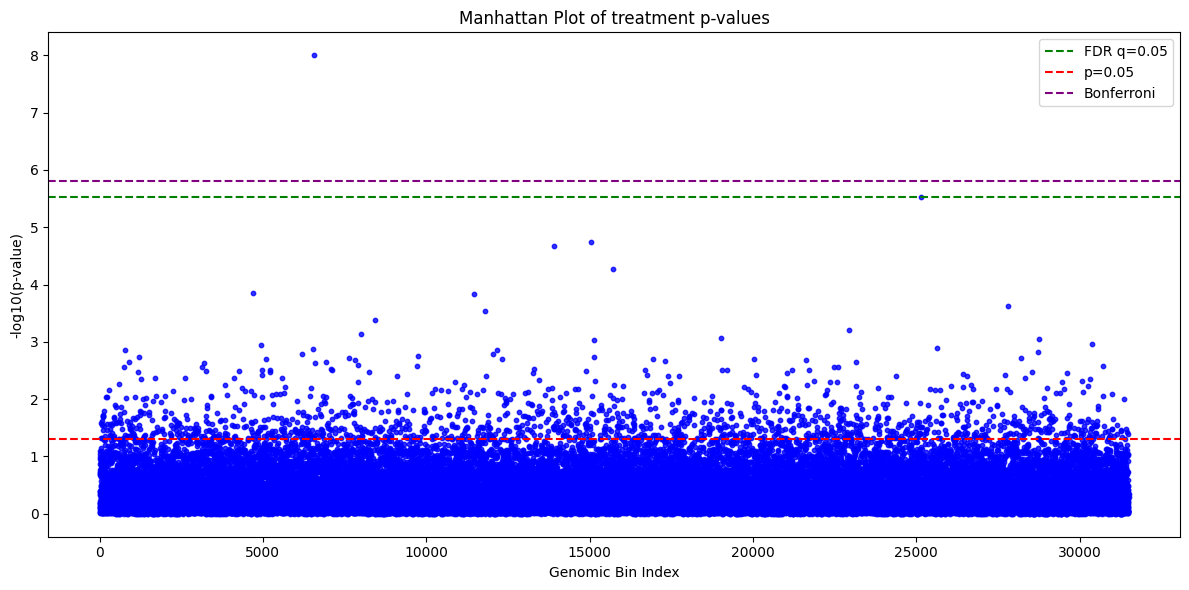

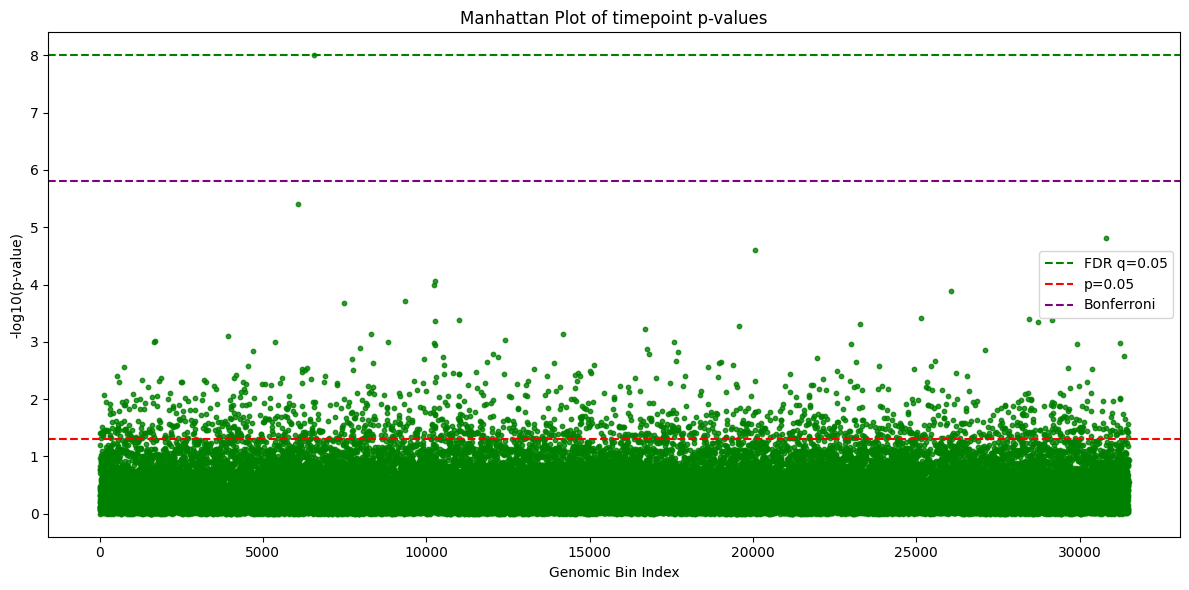

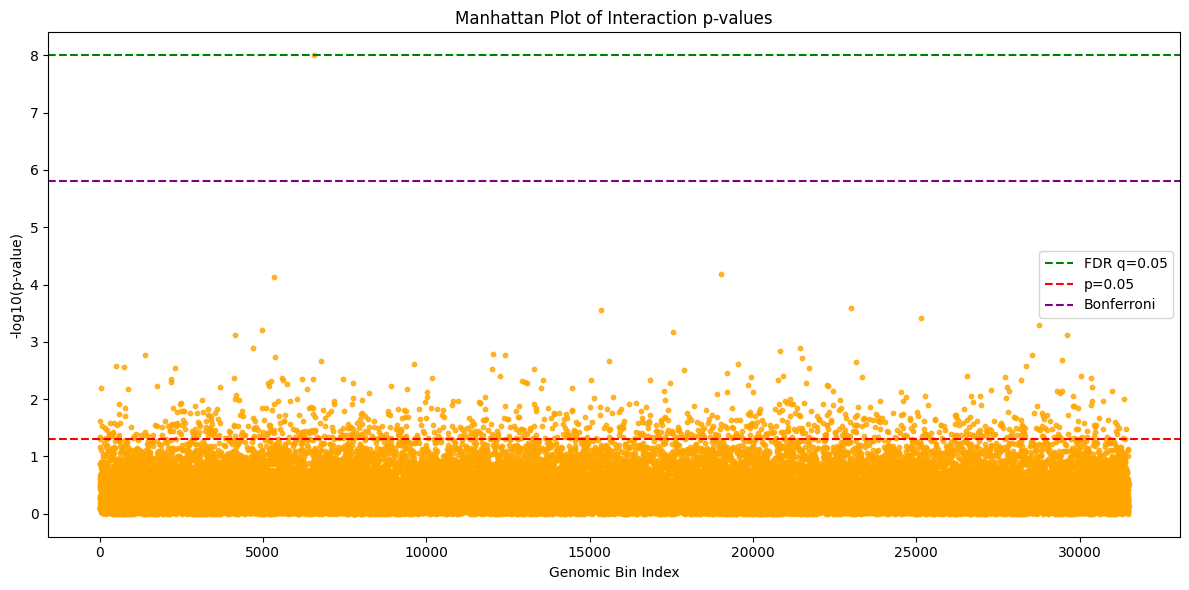

In [43]:
#Show and save visualizations
# For all bins
print("Starting general visualisations..")
#manhattan_plot(results_df, factor1_name, factor2_name, figures_dir)
manhattan_plot_separate(results_df, factor1_name, factor2_name, figures_dir)
#volcano_plot(results_df, factor1_name, factor2_name, figures_dir)
#pvalue_distribution(results_df, factor2_name, factor2_name, figures_dir)
significance_summary(file_path, results_df, factor1_name, factor2_name, data_dir)
print("Done with general visualisations")


In [23]:
! pwd

/cluster/home/taekim/stressed_mice/jupyter_notebooks


Starting specific visualisations..
Preparing top significant bins data...
Creating combined significant bins file with most significant factor...
Plotting top significant bins...
Bin plots complete. All plots saved to ../images/anova_results/cpg/indiv
Creating a combined heatmap of significant bins...
{'NC_000070.7+55651120': 'chr4+55651120', 'NC_000081.7+75438313': 'chr15+75438313'}
Combined heatmap complete. Heatmap saved to ../images/anova_results/cpg/combined_significance_heatmap.png
Legend saved separately to ../images/anova_results/cpg/heatmap_legend.png
Creating a combined heatmap of significant bins with z-score normalization...
Z-score range: -0.68 to 2.38
Z-score normalized heatmap complete. Files saved to:
  - ../images/anova_results/cpg/combined_significance_heatmap_zscore.png
  - ../images/anova_results/cpg/heatmap_legend_zscore.png
Creating a combined heatmap of significant bins with z-score normalization and clustering...
Z-score range: -0.68 to 2.38
Z-score normalized c

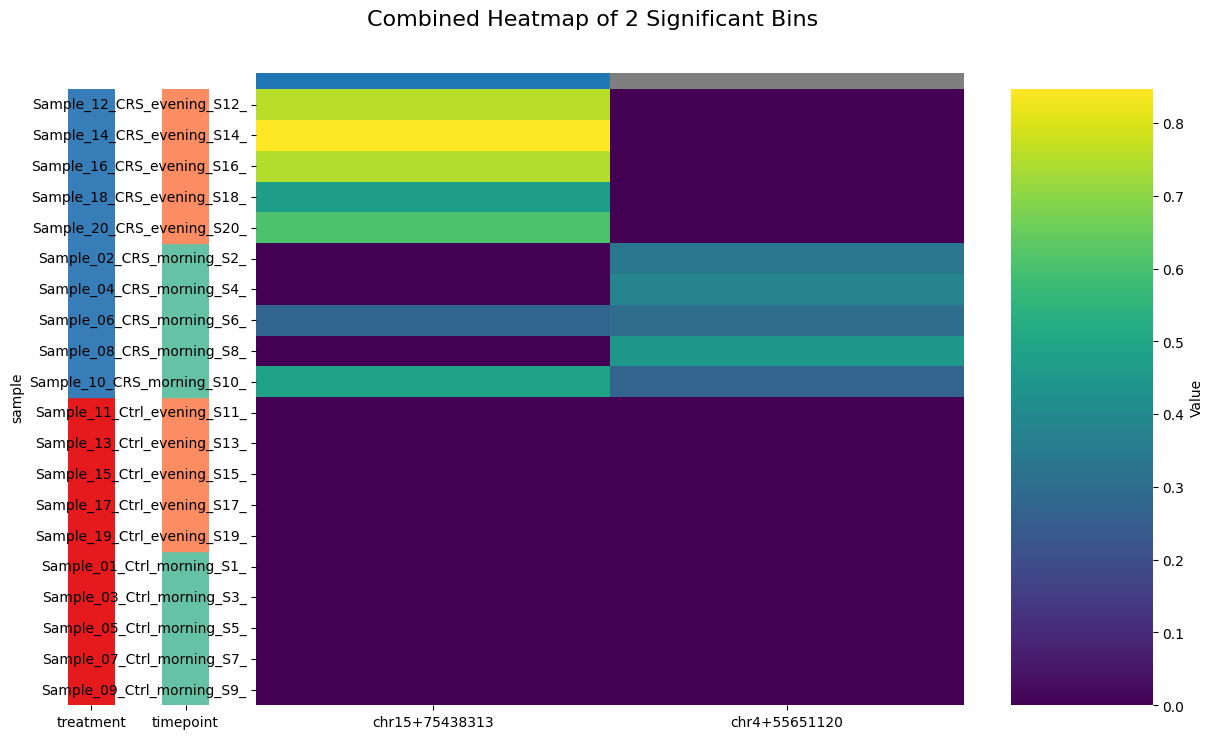

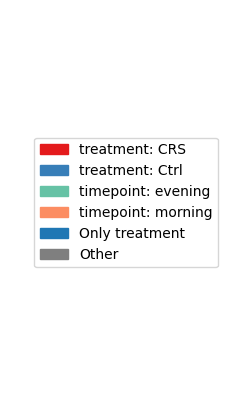

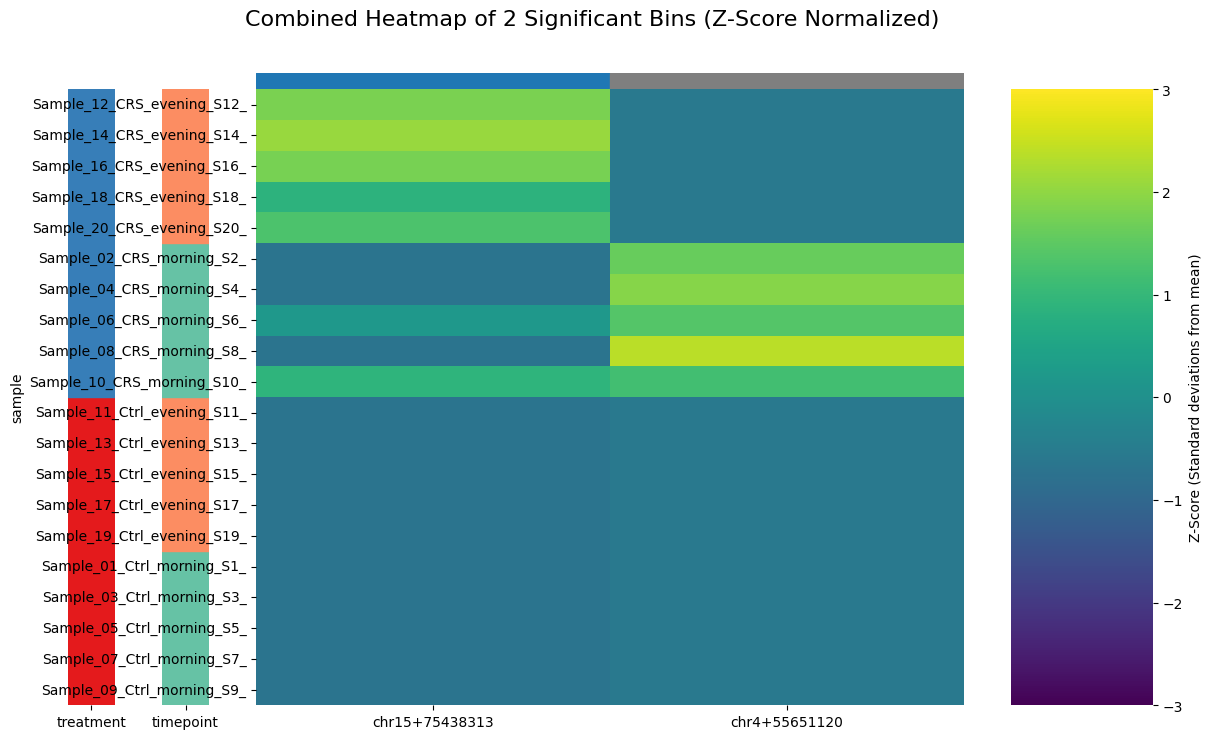

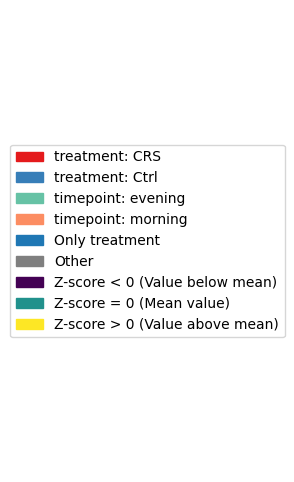

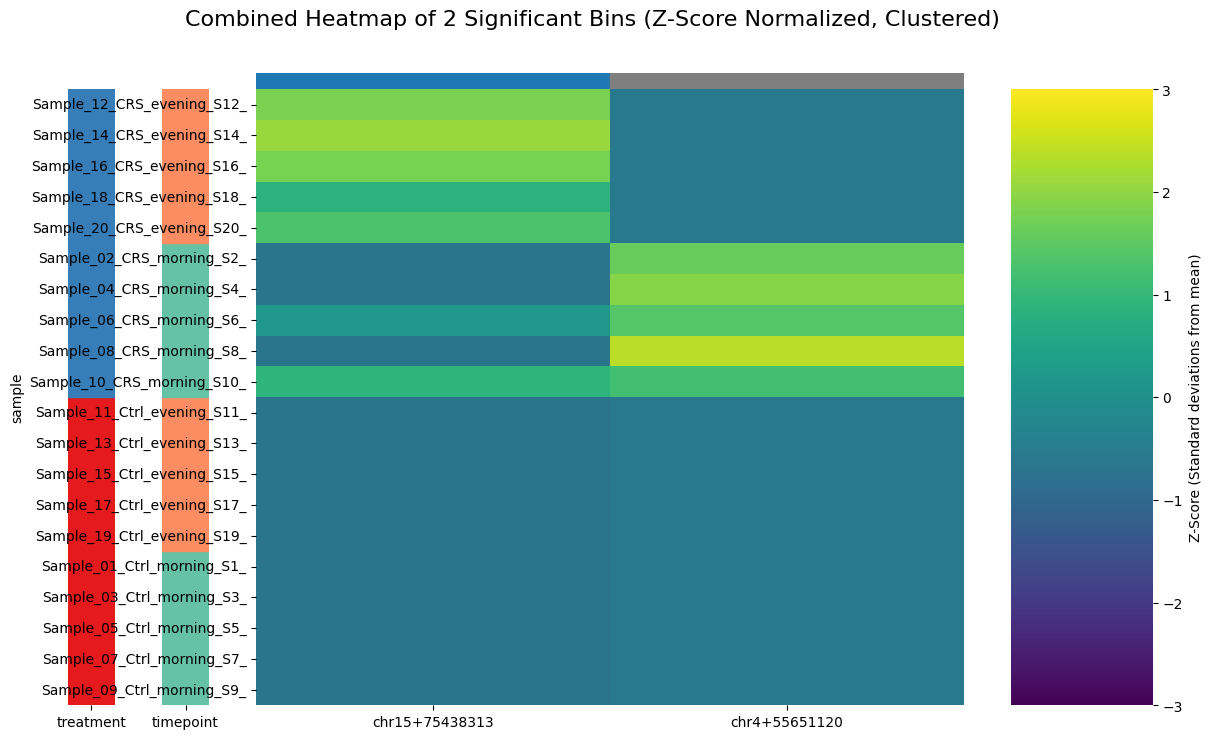

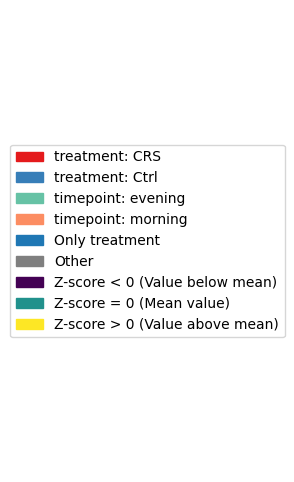

In [45]:
#For significant bins
print ("Starting specific visualisations..")
max_bins = 1000
table_path = '../data_additional/Chromosome_naming_table_17.09.2024_Vakil.tsv' #CHANGE PATH

# Prepare the data
top_bins_dict = prepare_significant_bins_data(results_df, factor1_name, factor2_name, max_bins, file_path, table_path, data_dir)

# Generate the plots

plot_significant_bins(pivot_df, metadata_df, top_bins_dict, factor1_name, factor2_name, indiv_dir)
create_heatmap_unified(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict, max_bins, figures_dir)
create_heatmap_unified_zscore(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict, max_bins, figures_dir)
create_heatmap_unified_zscore_clustered(pivot_df, bin_ids, metadata_df, results_df, factor1_name, factor2_name, top_bins_dict, max_bins, figures_dir)